### SageMaker PCA
- haimtran created on 03/10/2023
- double check on 30/05/2023

[payload max size](https://docs.aws.amazon.com/general/latest/gr/sagemaker.html)

In [ ]:
!python3 -m pip install matplotlib 
!python3 -m pip install boto3
!python3 -m pip install fsspec
!python3 -m pip install s3fs 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import boto3
import sagemaker
from sagemaker.amazon.pca import PCA
from sagemaker.amazon.amazon_estimator import RecordSet
from sagemaker import PCAPredictor
from sagemaker import get_execution_role
import json

In [ ]:
# %matplotlib notebook

In [3]:
role = get_execution_role()

In [4]:
sess = sagemaker.Session()

In [5]:
default_bucket = sess.default_bucket()

## upload to S3m

In [6]:
s3_client = boto3.client('s3')

In [7]:
s3_client.upload_file("./171A_raw.csv", default_bucket, "ecg/171A_raw.csv")

In [48]:
s3_client.upload_file("./171A_raw.csv", default_bucket, "ecg/transform-input/171A_raw.csv")

### download data from s3 

In [8]:
#s3_client.download_file(default_bucket, "ecg/171A_raw.csv", "171A_raw.csv")

### explore data 

In [9]:
# pandas can read directly from s3 
df = pd.read_csv(f"s3://{default_bucket}/ecg/171A_raw.csv",header=0,decimal=",",low_memory=False)

In [10]:
df.head()

,Real Time,Ch5,Ch6,Ch7,Ch8,BioRadio Event,Unnamed: 6
0,2021-12-09 12:20:46.3935,-0.00483427941799164,0.00440751761198044,0.00478646904230118,0.0098966583609581,0,NaN
1,2021-12-09 12:20:46.3955,-0.00482828915119171,0.00441303849220276,0.00479216873645782,0.00990407913923264,0,NaN
2,2021-12-09 12:20:46.3975,-0.00483635812997818,0.00440700352191925,0.0047864243388176,0.00989764183759689,0,NaN
3,2021-12-09 12:20:46.3995,-0.00485609471797943,0.00439200550317764,0.00477075576782227,0.00988166034221649,0,NaN
4,2021-12-09 12:20:46.4015,-0.00481210649013519,0.00442609190940857,0.00480430573225021,0.00991485267877579,0,NaN


In [11]:
df.fillna(0, inplace=True)

In [12]:
ecg = df[['Ch5', 'Ch6', 'Ch7', 'Ch8']].values.astype(dtype=np.float32)

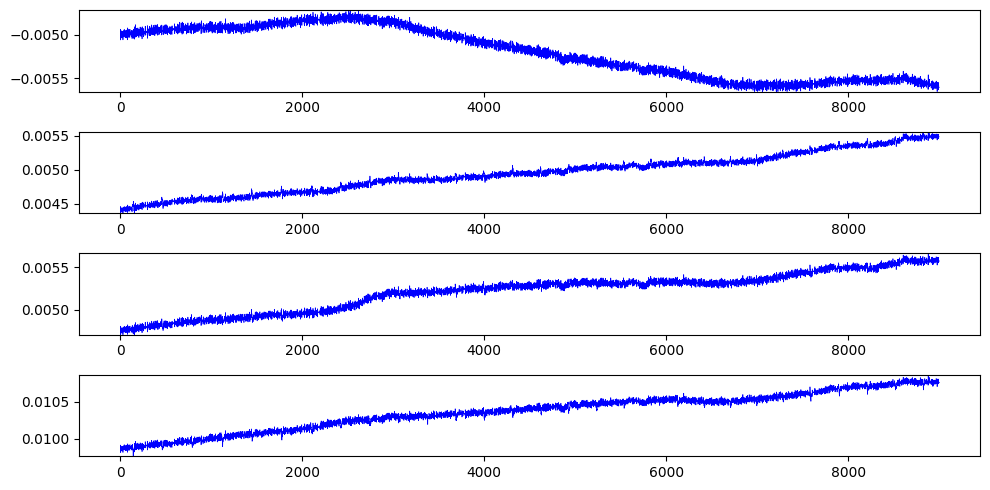

In [13]:
xmin,xmax=1000,10000
fig,axes = plt.subplots(4,1,figsize=(10,5))
for k in range(4):
    axes[k].plot(ecg[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(ecg[xmin:xmax,k]), np.max(ecg[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### feature processing 

In [14]:
normEcg = (ecg - np.mean(ecg, axis=0)) / np.std(ecg, axis=0)

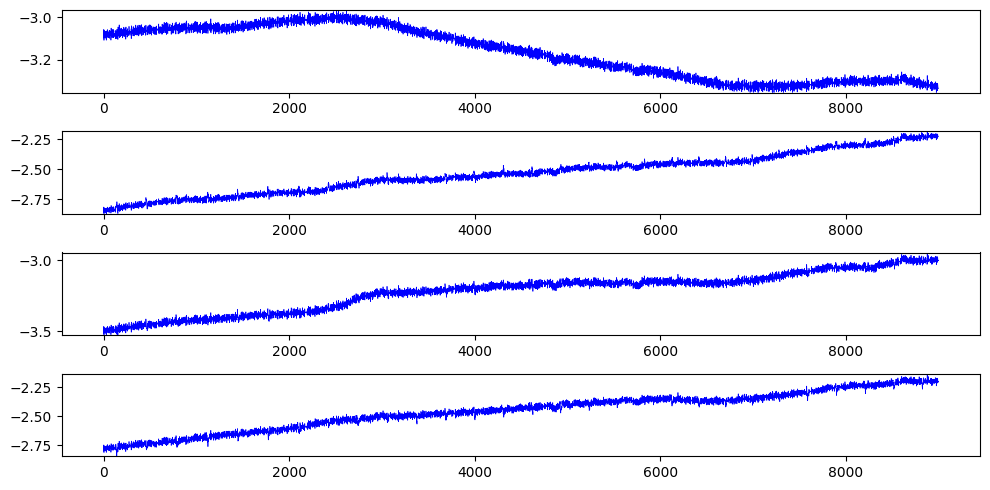

In [15]:
xmin,xmax=1000,10000
fig,axes = plt.subplots(4,1,figsize=(10,5))
for k in range(4):
    axes[k].plot(normEcg[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(normEcg[xmin:xmax,k]), np.max(normEcg[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### sagemaker pca train

In [29]:
pca = PCA(
    role=role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge',
    input_mode="Pipe",
    num_components=3)

In [30]:
# construct RecordSet data
# how to construct it from s3 csv data
record_set = pca.record_set(normEcg)
# print(record_set)

In [33]:
print(record_set)

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-ap-southeast-1-394599967678/sagemaker-record-sets/PCA-2023-05-31-08-06-59-280/.amazon.manifest', 'feature_dim': 4, 'num_records': 1557664, 's3_data_type': 'ManifestFile', 'channel': 'train'})


In [34]:
# # double check 
record_set = RecordSet(
    s3_data=f"s3://{default_bucket}/sagemaker-record-sets/PCA-2023-05-31-08-06-59-280/.amazon.manifest",
    num_records=1557664,
    feature_dim=4
)
print(record_set)

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-ap-southeast-1-394599967678/sagemaker-record-sets/PCA-2023-05-31-08-06-59-280/.amazon.manifest', 'feature_dim': 4, 'num_records': 1557664, 's3_data_type': 'ManifestFile', 'channel': 'train'})


### it takes about 2 minute until downloading the training image, and 2 minutes training  

In [35]:
# fit 
pca.fit(records=record_set)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: pca-2023-05-31-08-08-51-431


2023-05-31 08:08:51 Starting - Starting the training job...
2023-05-31 08:09:16 Starting - Preparing the instances for training......
2023-05-31 08:10:09 Downloading - Downloading input data...
2023-05-31 08:10:29 Training - Downloading the training image......
2023-05-31 08:11:50 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/31/2023 08:12:02 INFO 139959460529984] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[05/31/2023 08:12:02 INFO 139959460529984] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '4', 'mini_batch_size': '500', 'num_com

### sagemaker pca deploy
this takes about 6 minutes 
- real-time type 
- one variant  

In [36]:
pca.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: pca-2023-05-31-08-13-08-496
INFO:sagemaker:Creating endpoint-config with name pca-2023-05-31-08-13-08-496
INFO:sagemaker:Creating endpoint with name pca-2023-05-31-08-13-08-496


------------!

In [37]:
pca_predictor = PCAPredictor(
    endpoint_name="pca-2023-05-31-08-13-08-496")

In [38]:
np.shape(normEcg)

(1557664, 4)

In [39]:
# 413 error when data length more than threshold
result = pca_predictor.predict(normEcg[:100000,:])

In [ ]:
# plot transformed data 

In [40]:
result[0]

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.04966473579406738
      values: 1.0271497964859009
      values: 5.986490726470947
    }
  }
}

In [41]:
buffer = []
for x in result:
    buffer.append(x.label['projection'].float32_tensor.values)

In [42]:
buffer = np.array(buffer)

In [43]:
np.shape(buffer)

(100000, 3)

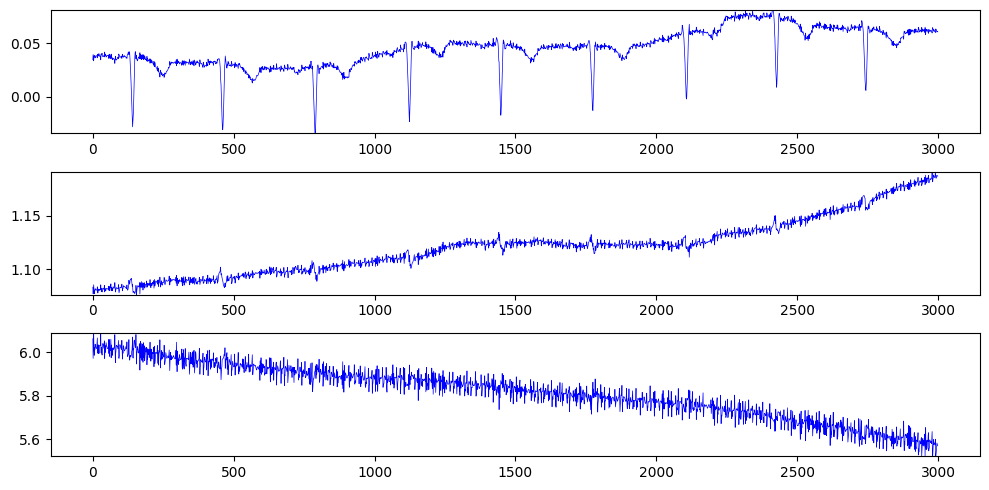

In [44]:
xmin,xmax=1000,4000
fig,axes = plt.subplots(3,1,figsize=(10,5))
for k in range(3):
    axes[k].plot(buffer[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(buffer[xmin:xmax,k]), np.max(buffer[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### batch transform 
- Transform clean data which contain 4 columns of ECG in double 
- Check clean_ecg.csv uploaded to s3://bucket/ecg/transform-input/

In [45]:
from sagemaker.transformer import Transformer

In [49]:
transformer = Transformer(
    model_name="pca-2023-05-31-08-13-08-496",
    instance_count=1,
    instance_type="ml.c4.xlarge",
    strategy="MultiRecord")

In [51]:
default_bucket

'sagemaker-ap-southeast-1-394599967678'

In [57]:
!aws s3 ls 's3://sagemaker-ap-southeast-1-394599967678/ecg/transform-input/'
# !aws s3 rm 's3://sagemaker-ap-southeast-1-394599967678/ecg/transform-input/171A_raw.csv' 

2023-05-31 08:22:39  166518545 171A_raw.csv
2023-05-31 08:42:22   75981131 base-processor_clean_data.csv
delete: s3://sagemaker-ap-southeast-1-394599967678/ecg/transform-input/171A_raw.csv


In [58]:
transformer.transform(
    data=f"s3://{default_bucket}/ecg/transform-input/",
    content_type="text/csv",
    split_type="Line"
)

INFO:sagemaker:Creating transform job with name: pca-2023-05-31-08-47-18-465


................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/31/2023 08:52:40 INFO 139742291797824] loaded entry point class algorithm.serve.server_config:config_api
[05/31/2023 08:52:40 INFO 139742291797824] nvidia-smi: took 0.030 seconds to run.
[05/31/2023 08:52:40 INFO 139742291797824] nvidia-smi identified 0 GPUs.
[05/31/2023 08:52:40 INFO 139742291797824] loading entry points
[05/31/2023 08:52:40 INFO 139742291797824] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[05/31/2023 08:52:40 INFO 139742291797824] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/31/2023 08:52:40 INFO 139742291797824] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[05/31/2023 08:52:40 INFO 139742291797824] loaded request iterator application/json
[05/31/2023 08:

In [ ]:
# print(record_set)

In [ ]:
# upload test data to s3
# np.savetxt("test_small.csv", normEcg[:10000,:], delimiter=",")
# s3_client.upload_file('test.csv', default_bucket, "ecg/test.csv")
# s3_client.upload_file('test_small.csv', default_bucket, 'ecg/test_small.csv')

In [59]:
output_prefix = transformer.output_path.split("/")[-1]
resp = s3_client.list_objects(Bucket=default_bucket, Prefix=output_prefix)
output_file = resp["Contents"][0]
s3_client.download_file(default_bucket,output_file["Key"],"transformed.csv")

In [60]:
with open("transformed.csv", "r") as file:
    buffer = [json.loads(line)['projection'] for line in file]

In [61]:
transformed = np.array(buffer)

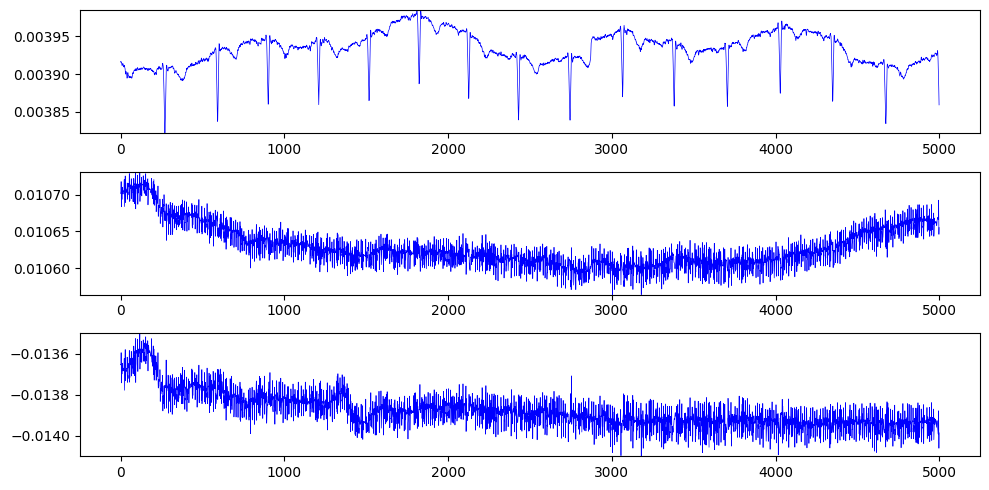

In [62]:
xmin,xmax=35000,40000
fig,axes = plt.subplots(3,1,figsize=(10,5))
for k in range(3):
    axes[k].plot(transformed[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(transformed[xmin:xmax,k]), np.max(transformed[xmin:xmax,k]))
fig.tight_layout()
plt.show()